In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm, tqdm_notebook, trange
pd.pandas.set_option('display.max_columns', None)

import Validation

C:\Users\shankar\Anaconda3\envs\tf\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('Prob_2_train.csv')
test = pd.read_excel('Test_dataset.xlsx', sheet_name = 'Test_dataset')
train.shape, test.shape

((10714, 28), (14498, 27))

In [3]:
data = pd.read_csv('prob_2_Final_FE_data.csv')
data.shape

(25212, 1017)

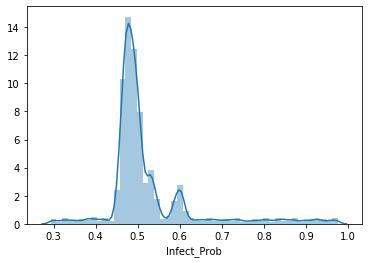

In [4]:
sns.distplot(train['Infect_Prob']/100)

In [5]:
y = train['Infect_Prob']/100

In [6]:
y.describe()

count    10714.000000
mean         0.522807
std          0.106747
min          0.292896
25%          0.472774
50%          0.490084
75%          0.527623
max          0.976320
Name: Infect_Prob, dtype: float64

In [7]:
target = pd.Series(np.where(y>0.5, 1, 0))
target.value_counts()

0    6569
1    4145
dtype: int64

In [8]:
target.value_counts(normalize=True)

0    0.613123
1    0.386877
dtype: float64

In [9]:
final_train = data[:train.shape[0]]
final_test = data[train.shape[0]:].reset_index(drop=True)
final_train.shape, final_test.shape

((10714, 1017), (14498, 1017))

In [10]:
final_train.head()

Region  Gender  Name  Married  Children  Occupation  Mode_transport  \
0       0       0     0        0       1.0           0               0   
1       0       0     1        0       2.0           0               1   
2       0       0     2        1       1.0           1               0   
3       0       0     3        0       1.0           2               2   
4       0       0     4        1       2.0           3               2   

   cases/1M  Deaths/1M  comorbidity  Age  Coma score  Pulmonary score  \
0         2          0            0   68           8                0   
1         2          0            1   64          15                1   
2         2          0            2   19          13                2   
3         2          0            3   33           9                3   
4         2          0            1   23           7                0   

   cardiological pressure     Diuresis  Platelets    HBB  d-dimer  Heart rate  \
0                       0  1743.465042      154.0   93.0    233.0        82.0   
1                       1   724.551191      121.0   56.0    328.0        89.0   
2                       2  1652.950459      124.0  137.0    213.0        77.0   
3                       3  1620.209623       98.0  167.0    275.0        64.0   
4                       0  1559.255771       21.0  153.0    331.0        71.0   

   HDL cholesterol  Charlson Index  Blood Glucose  Insurance   salary  \
0             58.0              27              7  3600000.0  1300000   
1             68.0               5              6  1600000.0   400000   
2             43.0              40              6  3400000.0   900000   
3             60.0              27              7   700000.0  2300000   
4             64.0              32              7  3200000.0  1100000   

   FT/month  Occupation_na  Children_na  Diuresis_na  Platelets_na  \
0       2.0              0            0            0             0   
1       1.0              0            0            0             0   
2       1.0              0            0            0             0   
3       1.0              0            0            0             0   
4       1.0              0            0            0             0   

   d-dimer_na  Heart_rate_na  Insurance_na  FT_na  Age_bins  \
0           0              0             0      0         5   
1           0              0             0      0         5   
2           0              0             0      0         1   
3           0              0             0      0         2   
4           0              0             0      0         1   

   dist_Children_from_5_nearest_neighbors  \
0                                     0.0   
1                                     0.6   
2                                     0.2   
3                                     0.0   
4                                     0.6   

   Children_divided_by_5_nearest_neighbors  Children_5_nearest_neighbors  \
0                                 1.000000                           1.0   
1                                 1.428571                           1.4   
2                                 1.250000                           0.8   
3                                 1.000000                           1.0   
4                                 1.428571                           1.4   

   dist_Children_from_10_nearest_neighbors  \
0                                      0.1   
1                                      0.8   
2                                     -0.1   
3                                     -0.2   
4                                      0.7   

   Children_divided_by_10_nearest_neighbors  Children_10_nearest_neighbors  \
0                                  1.111111                            0.9   
1                                  1.666667                            1.2   
2                                  0.909091                            1.1   
3                                  0.833333                            1.2  

In [11]:
X = final_train
y = target
test_X = final_test
X.shape, test_X.shape

((10714, 1017), (14498, 1017))

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

In [15]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

err_rf_ac = []
err_rf_f1 = []
err_rf_auc = []

y_pred_tot_rf = []
y_pred_tot_rf_prob = []


fold = KFold(n_splits=5, shuffle=True, random_state=42)
f = 0

for train_index, test_index in fold.split(X):
    f += 1
    print('*'*30+'Fold '+str(f)+'*'*30)
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf = RandomForestClassifier(random_state=1999, n_estimators=100)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    y_pred_prob = rf.predict_proba(X_test)[:,1]
    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred, average='weighted')
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print("AUC Score:", err_auc)
    
    test_pred = rf.predict(test_X)
    test_pred_proba = rf.predict_proba(test_X)[:,1]
    
    err_rf_ac.append(err_ac)
    err_rf_f1.append(err_f1)
    err_rf_auc.append(err_auc)
    
    y_pred_tot_rf.append(test_pred)
    y_pred_tot_rf_prob.append(test_pred_proba)
    

******************************Fold 1******************************
Accuracy: 0.9024731684554363
F1 Score: 0.9030800832636325
AUC Score: 0.9638526712124843
******************************Fold 2******************************
Accuracy: 0.8968735417638825
F1 Score: 0.8976598373335962
AUC Score: 0.9650663684229905
******************************Fold 3******************************
Accuracy: 0.8908072795146991
F1 Score: 0.8915274243194037
AUC Score: 0.9613103142178387
******************************Fold 4******************************
Accuracy: 0.9029398040130658
F1 Score: 0.9039178512111963
AUC Score: 0.9640912808312113
******************************Fold 5******************************
Accuracy: 0.8940242763772176
F1 Score: 0.8949430198145923
AUC Score: 0.9624439794066447


In [16]:
print(np.mean(err_rf_ac))
print(np.mean(err_rf_f1))
print(np.mean(err_rf_auc))

0.8974236140248604
0.8982256431884842
0.963352922818234


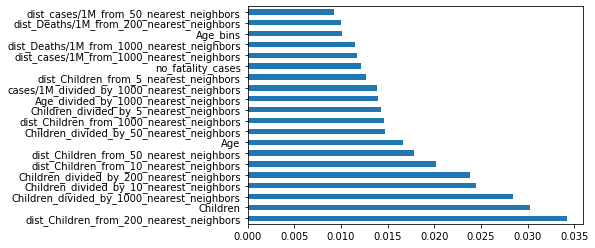

In [17]:
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [18]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

err_lgb_ac = []
err_lgb_f1 = []
err_lgb_auc = []

y_pred_tot_lgb = []
y_pred_tot_lgb_prob = []


fold = KFold(n_splits=5, shuffle=True, random_state=42)
f = 0
for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    m=LGBMClassifier(n_estimators=1000,random_state=1994,learning_rate=0.03,colsample_bytree=0.2,objective='binary',
                     scale_pos_weight=1)
    m.fit(X_train,y_train,eval_set=[(X_test, y_test)],eval_metric='auc', early_stopping_rounds=200,verbose=200)
    
    y_pred = m.predict(X_test)
    y_pred_prob = m.predict_proba(X_test)[:,1]
    
    test_pred = m.predict(test_X)
    test_pred_proba = m.predict_proba(test_X)[:,1]
    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred, average='weighted')
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    f += 1
    print("Fold:", f)
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print("AUC Score:", err_auc)
    print('\n')
    
    err_lgb_ac.append(err_ac)
    err_lgb_f1.append(err_f1)
    err_lgb_auc.append(err_auc)
    
    y_pred_tot_lgb.append(test_pred)
    y_pred_tot_lgb_prob.append(test_pred_proba)
    

Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.967787	valid_0's binary_logloss: 0.205427
Early stopping, best iteration is:
[23]	valid_0's auc: 0.969274	valid_0's binary_logloss: 0.401619
Fold: 1
Accuracy: 0.896406906206253
F1 Score: 0.8967052600591298
AUC Score: 0.9692739762833221


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.970113	valid_0's binary_logloss: 0.199858
[400]	valid_0's auc: 0.970743	valid_0's binary_logloss: 0.194623
Early stopping, best iteration is:
[383]	valid_0's auc: 0.970941	valid_0's binary_logloss: 0.194009
Fold: 2
Accuracy: 0.9160055996266916
F1 Score: 0.9167684064258254
AUC Score: 0.9709414926911889


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.967695	valid_0's binary_logloss: 0.210978
Early stopping, best iteration is:
[190]	valid_0's auc: 0.967832	valid_0's binary_logloss: 0.21133
Fold: 3
Accuracy: 0.9024731684554363
F1 Score: 0.903269949719

In [19]:
print(np.mean(err_lgb_ac))
print(np.mean(err_lgb_f1))
print(np.mean(err_lgb_auc))

0.9044238445105839
0.9051590365473366
0.9687779070837316


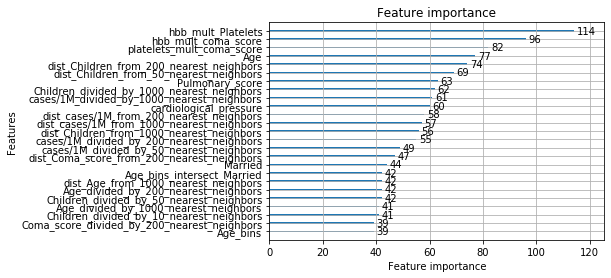

In [20]:
from lightgbm import plot_importance
plot_importance(m, max_num_features=25)

In [21]:
categorical_features_indices = np.where(X.dtypes == 'object')[0]
categorical_features_indices

array([], dtype=int64)

In [22]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
# from catoost import catClassifier
from catboost import CatBoostClassifier

err_cat_ac = []
err_cat_f1 = []
err_cat_auc = []

y_pred_tot_cat = []
y_pred_tot_cat_prob = []


fold = KFold(n_splits=10, shuffle=True, random_state=42)
f = 0
for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier( 
                         eval_metric='AUC', 
                         depth=6,
                         random_seed=42, 
                         iterations=1000, 
                         learning_rate=0.07,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1, 
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=50)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=50, cat_features=categorical_features_indices)
    y_pred = cat.predict(X_test)
    y_pred_prob = cat.predict_proba(X_test)[:,1]
    
    err_ac = accuracy_score(y_test, y_pred)
    err_f1 = f1_score(y_test, y_pred, average='weighted')
    err_auc = roc_auc_score(y_test, y_pred_prob)
    
    f += 1
    print("Fold:", f)
    print("Accuracy:", err_ac)
    print('F1 Score:', err_f1)
    print("AUC Score:", err_auc)
    print('\n')
    
    test_pred = cat.predict(test_X)
    test_pred_proba = cat.predict_proba(test_X)[:,1]
    
    err_cat_ac.append(err_ac)
    err_cat_f1.append(err_f1)
    err_cat_auc.append(err_auc)
    
    y_pred_tot_cat.append(test_pred)
    y_pred_tot_cat_prob.append(test_pred_proba)
    

Fold: 1
Accuracy: 0.9113805970149254
F1 Score: 0.9120875860722326
AUC Score: 0.967081486033683


Fold: 2
Accuracy: 0.8992537313432836
F1 Score: 0.8996251859672698
AUC Score: 0.9681157541448798


Fold: 3
Accuracy: 0.9029850746268657
F1 Score: 0.903520945330883
AUC Score: 0.9691867575122293


Fold: 4
Accuracy: 0.9020522388059702
F1 Score: 0.9029400784588523
AUC Score: 0.96427547322988


Fold: 5
Accuracy: 0.8851540616246498
F1 Score: 0.8859570349404755
AUC Score: 0.961368885156414


Fold: 6
Accuracy: 0.9066293183940243
F1 Score: 0.907351550950167
AUC Score: 0.9704452611388493


Fold: 7
Accuracy: 0.9187675070028011
F1 Score: 0.9193046882340629
AUC Score: 0.9700718802435575


Fold: 8
Accuracy: 0.8982259570494865
F1 Score: 0.8995047692372286
AUC Score: 0.9642315623483746


Fold: 9
Accuracy: 0.900093370681606
F1 Score: 0.9013662335443772
AUC Score: 0.9632019035180557


Fold: 10
Accuracy: 0.896358543417367
F1 Score: 0.8969764370757277
AUC Score: 0.9661661566393839




In [23]:
print(np.mean(err_cat_ac))
print(np.mean(err_cat_f1))
print(np.mean(err_cat_auc))

0.9020900399960979
0.9028634509811276
0.9664145119965306


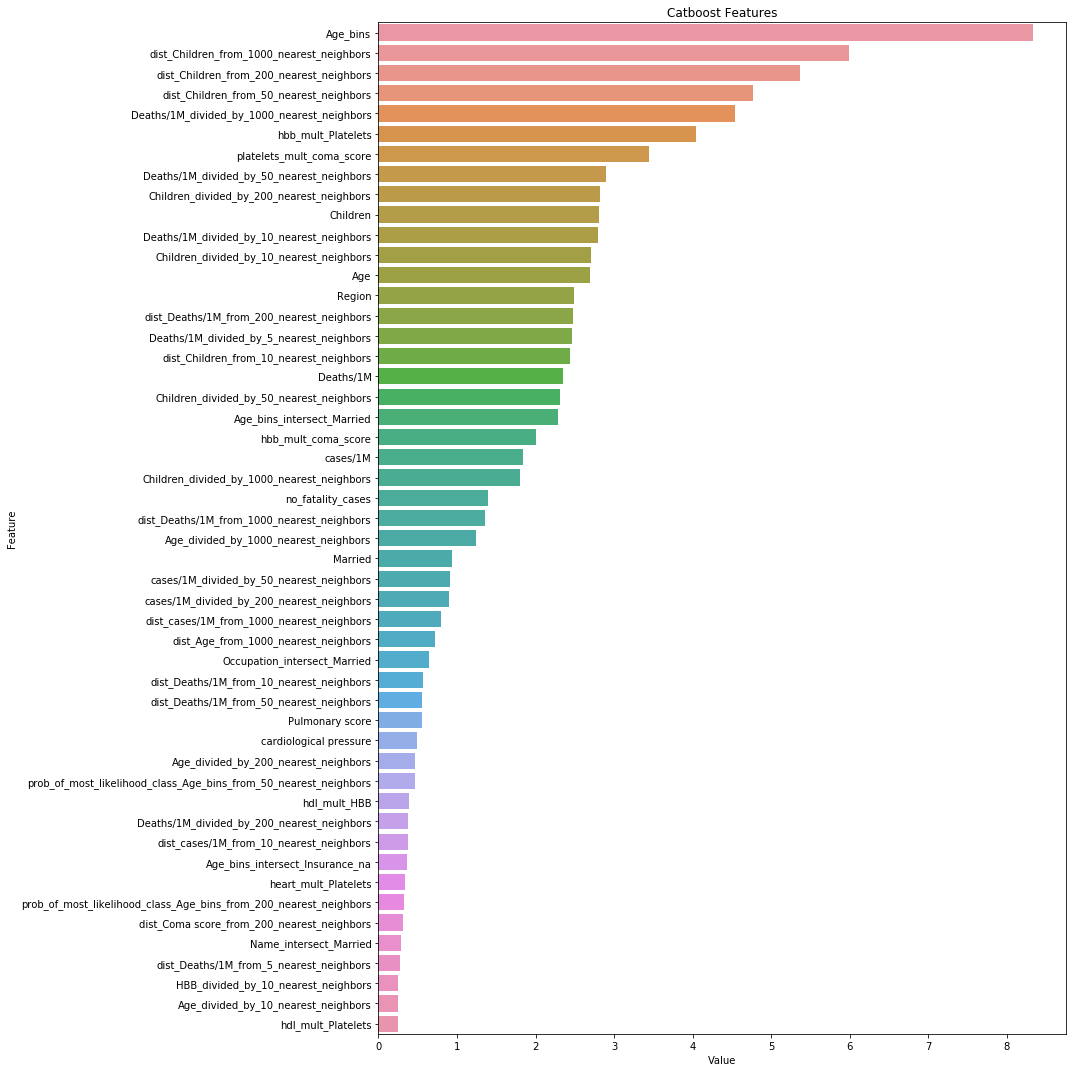

In [24]:
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

In [25]:
pred1 = np.mean(y_pred_tot_rf_prob, 0)*100
pred2 = np.mean(y_pred_tot_lgb_prob, 0)*100
pred3 = np.mean(y_pred_tot_cat_prob, 0)*100

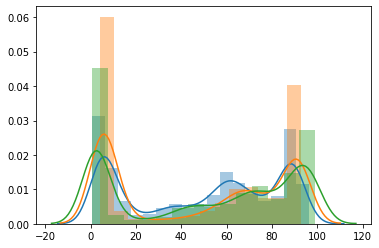

In [26]:
sns.distplot(pred1)
sns.distplot(pred2)
sns.distplot(pred3)

In [27]:
pred = (pred1+pred2+pred3)/3

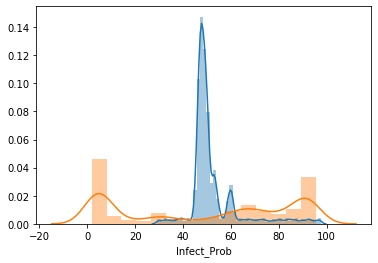

In [28]:
sns.distplot(train['Infect_Prob'])
sns.distplot(pred)

In [29]:
test['Infect_Prob'] = pred
test.to_csv('Prob2_Final_Answer.csv', index=False)